# Spot Price Forecasting

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import datetime
import pandas as pd
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

from utils import *
from latexify import *
golden_mean = (np.sqrt(5) - 1.0) / 2.0  # Aesthetic ratio

## Train and test data sets

In [2]:
# Read data from CSV files and create a pandas series
df = pd.read_csv("data/spot_price_data.csv", index_col=0)
df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')
spot_price_data = df["Spot Price (NOK/kWh)"]

spot_price_data.to_pickle("data/spot_price_data.pickle")

# Split data into train set and test set
train = spot_price_data[spot_price_data.index.year <= 2021]
test = spot_price_data[spot_price_data.index.year > 2021]

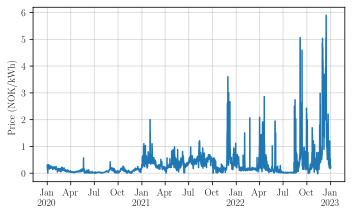

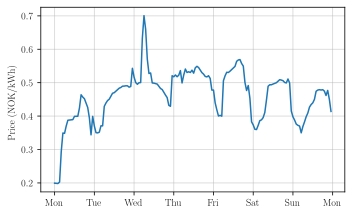

In [3]:
class JanYearDateFormatter(mdates.DateFormatter):
    def __init__(self, fmt='%b'):
        super().__init__(fmt)

    def __call__(self, x, pos=0):
        dt = mdates.num2date(x)
        if dt.month == 1:
            return dt.strftime('%b\n%Y')
        else:
            return dt.strftime('%b')

# Plot spot price data (2020-2022)
latexify(fig_width=5)
fig, ax = plt.subplots()
plt.plot(spot_price_data, color="tab:blue")
plt.ylabel("Price (NOK/kWh)")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(JanYearDateFormatter())
plt.xticks(rotation=0, ha='center')
plt.tight_layout()

plt.savefig("figures/spot_prices_three_years.pdf")
    
# Plot spot prices for one week in January 2022
latexify(fig_width=5)
fig, ax = plt.subplots()
week_data = spot_price_data.loc['2022-01-03':'2022-01-09']
ax.plot(week_data.values, color="tab:blue")
ax.set_ylabel("Price (NOK/kWh)")
ax.set_xticks(np.arange(0, 24 * 7 + 1, 24))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun", "Mon"])
plt.tight_layout()

plt.savefig("figures/spot_prices_load_one_week.pdf")

## Seasonal baseline forecast

In [4]:
PERIODS = [period / harmonic for harmonic in [1, 2, 3, 4] for period in [24, 24*7, 24*365]]
PERIODS = [3600 * period for period in PERIODS]

def featurize_for_baseline(data, periods):
    seconds = data.index.astype(np.int64) / 1E9
    X = np.zeros((len(seconds), 1 + 2 * len(periods)))
    trig_functions = [np.sin, np.cos]

    for idx, (period, trig) in enumerate([(p, t) for p in periods for t in trig_functions]):
        X[:, idx] = trig(2 * np.pi * seconds / period)

    X[:, -1] = np.ones(len(seconds))
    y = data.values
    return X, y

# Featurize train and test data
Xtr, ytr = featurize_for_baseline(train, PERIODS)
Xte, yte = featurize_for_baseline(test, PERIODS)

def fit_seasonal_baseline(X, y, reg_weight=0.001):
    params = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.sum_squares(X @ params - y) + reg_weight * cp.sum_squares(params))
    problem = cp.Problem(objective)
    problem.solve()
    return params.value

# Fit seasonal baseline to train data
baseline_params = fit_seasonal_baseline(Xtr, ytr)

def predict_with_baseline(X, parameters):
    return X @ parameters

# Make predictions and calculate RMSE
train_baseline = predict_with_baseline(Xtr, baseline_params)
test_baseline = predict_with_baseline(Xte, baseline_params)
def RMSE(array):
    return np.sqrt(np.mean(array**2))
train_rmse = RMSE(train.values - train_baseline)
test_rmse = RMSE(test.values - test_baseline)

print('Baseline train RMSE', train_rmse)
print('Baseline test RMSE', test_rmse)

# Create prediction Series
train_baseline_series = pd.Series(index=train.index, data=train_baseline)
test_baseline_series = pd.Series(index=test.index, data=test_baseline)
baseline = pd.concat([train_baseline_series, test_baseline_series])


# Extend baseline to 2023
date_range_2023 = pd.date_range(start='2023-01-01 00:00:00', end='2023-12-31 23:00:00', freq='H')
dummy_series_2023 = pd.Series(index=date_range_2023, dtype='float64')
X_2023, _ = featurize_for_baseline(dummy_series_2023, PERIODS)
baseline_2023 = predict_with_baseline(X_2023, baseline_params)
baseline_2023_series = pd.Series(index=date_range_2023, data=baseline_2023)
baseline = pd.concat([baseline, baseline_2023_series])

baseline.to_pickle("data/spot_price_baseline.pickle")

Baseline train RMSE 0.24063545848293558
Baseline test RMSE 0.6696248843116066


Text(0.5, 1.0, 'Prices and baseline for one week in June 2022')

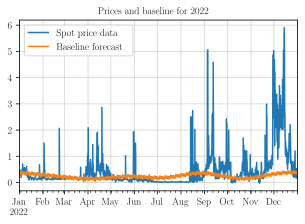

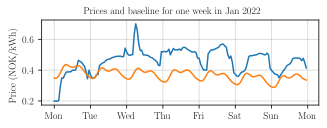

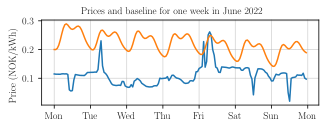

In [5]:
# Plot prices and baseline for the whole test year
plt.figure()
latexify(fig_width=5)
test.plot(label="Spot price data")
baseline[baseline.index.year == 2022].plot(label="Baseline forecast")
plt.title("Prices and baseline for 2022")
plt.legend()

# Plot prices and baseline for one week in January 2022
latexify(fig_width=5, fig_height=5*golden_mean/2)
fig, ax = plt.subplots()
ax.plot(test.loc['2022-01-03':'2022-01-09'].values, color="tab:blue")
ax.plot(test_baseline_series.loc['2022-01-03':'2022-01-09'].values, color="tab:orange")
plt.ylabel("Price (NOK/kWh)")
ax.set_xticks(np.arange(0, 24 * 7 + 1, 24))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun", "Mon"]);
plt.title("Prices and baseline for one week in Jan 2022")

# Plot prices and baseline for one week in June 2022
latexify(fig_width=5, fig_height=5*golden_mean/2)
fig, ax = plt.subplots()
ax.plot(test.loc['2022-06-06':'2022-06-12'].values, color="tab:blue")
ax.plot(test_baseline_series.loc['2022-06-06':'2022-06-12'].values, color="tab:orange")
plt.ylabel("Price (NOK/kWh)")
ax.set_xticks(np.arange(0, 24 * 7 + 1, 24))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun", "Mon"]);
plt.title("Prices and baseline for one week in June 2022")